In [1]:
#Set of scalar equations implemented in CAMB, and calculation of the line-of-sight sources
#indices are: g - photons, r- massless neutrinos, c - CDM, b - baryons, de - dark energy, nu - massive neutrinos
# kappa = 8 pi G, Pi is anisotropic stress, q =(rho+p)v the heat flux (and for components rho_i q_i = (rho_i+p_i)v_i)
# z is the perturbation to the expansion, h perturbation to the scale factor, sigma the shear
# phi the Weyl potential, and eta the 3-curvature. Equations are in a general gauge
# Equations are implemented in CAMB in the CDM frame (synchronous gauge, but using variables above). 
# There are functions to convert into Newtonian and synchronous gauge metric variables
# Note the code calls Delta_i density perturbation variables clxi

%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
import six

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')
import sympy
from sympy import diff, Eq, simplify, Function
from sympy.abc import t, kappa, K, k
from sympy.utilities.codegen import codegen

checks = True

#Background variables

tau0 = sympy.Symbol('tau0', description = 'conformal time today')
tau_maxvis = sympy.Symbol('tau_maxvis', description = 'conformal time of peak visibility')

f_K = Function ('f_K', description ='comoving angular diameter distance')

H = Function('H', description = 'comoving hubble parameter', camb_var = 'adotoa')(t)
rho = Function('rho', description = 'total density', camb_var = 'grho', camb_sub = 'grho/kappa/a**2')(t)
P = Function('P', description = 'total pressure', camb_var = 'gpres', camb_sub = 'gpres/kappa/a**2')(t)
a = Function('a', description = 'scale factor')(t)

rho_b = Function('rho_b', description = 'baryon density', camb_var = 'grhob_t', camb_sub = 'grhob_t/kappa/a**2')(t)
rho_c = Function('rho_c', description = 'CDM density', camb_var = 'grhoc_t', camb_sub = 'grhoc_t/kappa/a**2')(t)
rho_g = Function('rho_g', description = 'photon density', camb_var = 'grhog_t', camb_sub = 'grhog_t/kappa/a**2')(t)
rho_r = Function('rho_r', description = 'massless neutrino density', camb_var = 'grhor_t', camb_sub = 'grhor_t/kappa/a**2')(t)
rho_nu = Function('rho_nu', description = 'massive neutrino density', camb_var = 'grhonu_t', camb_sub = 'grhonu_t/kappa/a**2')(t)
rho_de = Function('rho_de', description = 'dark energy density', camb_var = 'grhov_t', camb_sub = 'grhov_t/kappa/a**2')(t)

p_b = Function('p_b', description = 'baryon pressure', camb_sub='0')(t)
p_nu = Function('p_nu', description = 'massive neutrino pressure')(t)
w_de = Function('w_de', camb_var='w_lam', description = 'fluid dark energy equation of state')(t)
p_g = rho_g/3
p_r = rho_r/3
p_c = 0
p_de = w_de*rho_de

opacity = Function('opacity', description = 'opacity, a n_e sigma_t')(t)
visibility = Function('visibility', description = 'ionization visibility')(t)
exptau = Function('exptau', description = 'exp(-tau)')(t)


def subs(eqs,expr):
    #generalization to act on lists of equations, and support using Eq equations.
    #lists are substituted irrespective of order, so no RHS variables are substituted by other elements
    if isinstance(expr, (list, tuple)):
        res = [subs(eqs,ex) for ex in expr]
        return [ x for x in res if x != True]
    if not isinstance(expr,sympy.Expr): return expr
    if isinstance(eqs, dict):
        return expr.subs(eqs)
    else:
        if not isinstance(eqs,(list,tuple)):
            return expr.subs(eqs.lhs,eqs.rhs)
        eqs = [(eq.lhs,eq.rhs) for eq in eqs]        
        #must use dict in order for rhs not to be substituted by subsequent lhs
        return expr.subs(dict(eqs))

def solve(eq, x):
    res= sympy.solve(eq,x)
    if len(res)==1:
        return res[0]
    else:
        return res

half = sympy.Rational(1,2)
third = sympy.Rational(1,3)
Kf =  sympy.IndexedBase('Kf', shape=(sympy.oo,))
K_fac = sympy.Symbol('Kf_1') #currently sympy bugs just using Kf[1], so treat as separate symbol
K_fac_sub = 1-3*K/k**2
K_sub = Eq(K,solve(K_fac_sub-K_fac,K))


H_t = diff(a,t)/a
dH = -a**2/6*kappa*(rho+3*P)
Friedmann = Eq(H**2,a**2*kappa*rho/3-K)
Friedmann_subs = [Friedmann, Eq(diff(H,t),dH), Eq(diff(a,t),a*H)]
Friedmann_Kfac_subs = subs(K_sub, Friedmann_subs)

sympy.init_printing()

delta_frame = sympy.Symbol('uprime')(t)
def LinearPerturbation(name, species=None, camb_var=None, camb_sub = None, frame_dependence = None, description=None):
    f=sympy.Function(name, species=species, camb_var=camb_var, camb_sub=camb_sub, perturbation_order = 1,
                        frame_dependence = frame_dependence, description = description)   
    return f(t)
    
def list_perturbations(expr, lst=None):
     if lst is None: lst=[]
     if getattr(expr, 'perturbation_order', None) and not expr in lst:
            lst.append(expr)
     for arg in expr.args:
        list_perturbations(arg, lst)
     return lst
    
def list_frame_dependent_vars(expr, lst=None):
     if lst is None: lst=[]
     if getattr(expr, 'frame_dependence', None) and not expr in lst:
            lst.append(expr)
     for arg in expr.args:
        list_frame_dependent_vars(arg, lst)
     return lst

def simplify_sum(expr):
    if isinstance(expr,sympy.Add):
        return sympy.Add(*[simplify(term) for term in expr.args])
    else:
        return expr
    

def frame_change(expr, delta_u = None, total = False):
    if getattr(expr, 'frame_dependence',None):
        res = expr.frame_dependence
        if delta_u is not None:  
            res = res.subs(delta_frame, delta_u)
        if total: res += expr
        return res
    else:
        if isinstance(expr, (list,tuple)): return [frame_change(x) for x in expr]
        perts = list_frame_dependent_vars(expr)
        res = subs([Eq(pert,pert + pert.frame_dependence) for pert in perts], expr)
        if delta_u is not None and isinstance(res,sympy.Expr):
            res = res.subs(delta_frame, delta_u)
        if not total: res -= expr
        res = simplify(res).expand()
        return simplify_sum(res.collect(list_frame_dependent_vars(res)))
        


#Perturbation variables

#gauge-invariant potential
phi = LinearPerturbation('phi', description = 'Weyl potential')

eta = LinearPerturbation('eta', camb_var='etak', camb_sub = '-2*etak/k',description = 'three-curvature',
                              frame_dependence = -2*K_fac*H*delta_frame/k)

sigma = LinearPerturbation('sigma', description = 'shear',
                           frame_dependence = delta_frame)

A =  LinearPerturbation('A', camb_sub=0, description = 'acceleration',
                        frame_dependence = (diff(delta_frame,t)+H*delta_frame)/k)

z =  LinearPerturbation('z', description = 'expansion rate perturbation',
#                        frame_dependence = delta_frame - 3*(dH- H**2)*delta_frame/k**2)
                        frame_dependence =K_fac*delta_frame + 3*kappa*a**2*(rho+P)*delta_frame/(2*k**2))

hdot = LinearPerturbation('hdot', camb_sub=k/3*z, description = 'time derivative of scale factor perturbation',
                        frame_dependence = k*delta_frame/3 - diff(delta_frame*H,t)/k)


delta =  LinearPerturbation('delta', camb_var = 'dgrho', camb_sub='dgrho/kappa/a**2', description = 'total density perturbation',
                        frame_dependence = 3*H*(rho+P)*delta_frame/k)

delta_P =  LinearPerturbation('delta_P', camb_sub='error', description = 'total pressure perturbation',
                        frame_dependence = -diff(P,t)*delta_frame/k)

q = LinearPerturbation('q', camb_var='dgq', camb_sub ='dgq/kappa/a**2', description = 'total heat flux',
                              frame_dependence = -(rho+P)*delta_frame)

Pi = LinearPerturbation('Pi', camb_var ='dgpi', camb_sub='dgpi/a**2/kappa', description = 'total anisotropic stress')



#quadrupole source
polter  = sympy.Symbol('polter')(t)

#Newtonian gauge variables (in general equal to gauge invariant potentials)
Phi_N = LinearPerturbation('Phi_N', description ='Newtonian gauge curvature potential')
Psi_N = LinearPerturbation('Psi_N', description ='Newtonian gauge acceleration potential')

#Synchronous gauge variables
eta_s = LinearPerturbation('eta_s', description = 'Synchronous gauge curvature variable')
hdot_s = LinearPerturbation('hdot_s', description = 'Synchronous gauge diff(h,t)')

#velocities, and dimensionless heat flux [(rho_i+P_i)v_i = rho_i q_i]

q_r = LinearPerturbation('q_r', species='r', camb_var='qr', description = 'massless neutrino heat flux',
                              frame_dependence = -4*delta_frame/3)
q_g = LinearPerturbation('q_g', species='g', camb_var='qg', description = 'photon heat flux'  ,
                              frame_dependence = -4*delta_frame/3)
q_nu = LinearPerturbation('q_nu', species='nu', camb_var='qnu', description = 'massive neutrino heat flux',
                              frame_dependence = -(1+p_nu/rho_nu)*delta_frame)

v_c = LinearPerturbation('v_c', species='c',  description = 'CDM velocity',
                              frame_dependence = -delta_frame)
v_b = LinearPerturbation('v_b', species='b',  camb_var='vb',  description = 'baryon velocity',
                              frame_dependence = -delta_frame)
v_de = LinearPerturbation('v_de', species='de',  camb_var='vq',  description = 'dark energy velocity',
                              frame_dependence = -delta_frame)
Delta_b = LinearPerturbation('Delta_b', species='b',  camb_var='clxb',  description = 'fractional baryon density perturbation',
                              frame_dependence = 3*H*(1+p_b/rho_b)*delta_frame/k)
Delta_c = LinearPerturbation('Delta_c', species='c',  camb_var='clxc',  description = 'fractional CDM density perturbation', 
                              frame_dependence = 3*H*delta_frame/k)
Delta_r = LinearPerturbation('Delta_r', species='r',  camb_var='clxr',  
                             description = 'fractional massless neutrino density perturbation', 
                              frame_dependence = 4*H*delta_frame/k)

Delta_nu = LinearPerturbation('Delta_nu', species='nu',  camb_var='clxnu',  
                             description = 'fractional massive neutrino density perturbation', 
                              frame_dependence = 3*H*(1+p_nu/rho_nu)*delta_frame/k)
Delta_P_nu =  LinearPerturbation('Delta_P_nu', camb_sub='error', description = 'fractional massive neutrino pressure perturbation',
                        frame_dependence = -diff(p_nu,t)/rho_nu*delta_frame/k)


Delta_g = LinearPerturbation('Delta_g', species='g',  camb_var='clxg',  description = 'fractional CDM density perturbation', 
                              frame_dependence = 4*H*delta_frame/k)
Delta_de = LinearPerturbation('Delta_de', species='de',  camb_var='clxq',  description = 'fractional dark energy density perturbation', 
                              frame_dependence = 3*H*(1+w_de)*delta_frame/k)
#Sound speeds
csq_b = LinearPerturbation('c_sb^2', species='b',  camb_var='cs2', description = 'baryon sound speed')
csq_b.frame_dependence = (csq_b*Delta_b - diff(p_b,t)/rho_b*delta_frame/k)/(Delta_b + 3*H*(1+p_b/rho_b)*delta_frame/k) - csq_b 

#dark energy sound speed defined in rest frame so gauge invariant
csqhat_de = LinearPerturbation('chat_sde^2', species='de',  camb_var='cs2_lam',  
                             description = 'rest frame dark energy sound speed')

#Anisotropic stress
pi_g = LinearPerturbation('pi_g', species='g',  camb_var='pig', description = 'photon anisotropic stress')
pi_r = LinearPerturbation('pi_r', species='r',  camb_var='pir', description = 'massless neutrino anisotropic stress')
pi_nu = LinearPerturbation('pi_nu', species='r',  camb_var='pinu', description = 'massive neutrino anisotropic stress')

#frame names specify a frame where a certain variable is zero
frame_names = {'CDM':v_c, 'Newtonian':sigma, 'comoving': q, 
              'flat': eta, 'constant density': delta}

def make_gauge_invariant(expr, frame = 'CDM'):
    """
    Makes the quantity gauge invariant, assuming currently evaluated in frame 'frame'.
    frame can either be a string frame name, or a variable that is zero in the current frame,
    e.g. frame = Delta_g gives the constant photon density frame.
    """
    if isinstance(frame,six.string_types):
        if not frame in frame_names: raise ValueError('Unknown frame names: %s'%frame)
        frame =frame_names[frame]
    if isinstance(expr, Eq): return simplify(Eq(make_gauge_invariant(expr.lhs, frame), make_gauge_invariant(expr.rhs, frame)))
    if isinstance(expr, (list,tuple)): return [make_gauge_invariant(x, frame) for x in expr]
    #do frame change to make frame variable zero
    #special case of frame=A, equivalent to v_c frame by evolution equation
    if frame==A: frame = v_c
    delta_u = solve(frame_change(frame, total=True), delta_frame)
    if delta_frame in delta_u.atoms(Function):
        raise ValueError('Cannot solve for change of frame. Currently only supports algebraic frame changes: %s'%delta_u)
    return frame_change(expr, delta_u = delta_u, total = True)


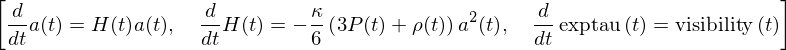

In [3]:
background_eqs = [
    Eq(diff(a,t),H*a),
    Eq(diff(H,t),dH),
    Eq(diff(exptau,t),visibility)
]
display(background_eqs)

In [4]:
sys.path.insert(0,r'c:\work\dist\git\camb\pycamb')
from camb.baseconfig import dll_import, camblib
import camb, ctypes
test_f = camblib.__handles_MOD_camb_testfunction
test_f.argtypes = [ctypes.c_voidp,ctypes.POINTER(ctypes.c_double)]
test_f.restype = ctypes.c_double

In [5]:
from sympy.utilities.autowrap import autowrap
f= autowrap(kappa**3, tempdir=r'z:')

In [6]:
xval = ctypes.c_double()
xval.value = 11.
PyCObject_AsVoidPtr = ctypes.PYFUNCTYPE(ctypes.c_void_p, ctypes.py_object)(
                          ('PyCObject_AsVoidPtr', ctypes.pythonapi))
addr = PyCObject_AsVoidPtr(f._cpointer)
test_f(ctypes.cast(addr, ctypes.c_voidp),  ctypes.byref(xval))

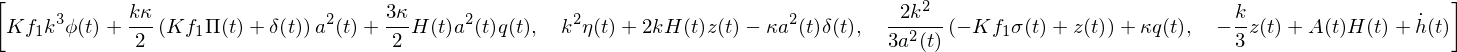

In [7]:
#constraint equations relating variables
cons1 = k**3*K_fac*phi+kappa/2*a**2*k*(delta+Pi*K_fac)  +3*kappa/2*a**2*H*q
cons2 = k**2*eta-kappa*a**2*delta + 2*k*H*z
cons3 = 2*third*(k/a)**2*(z-K_fac*sigma)+kappa*q
cons4 = hdot - k/3*z+H*A
constraints = [cons1,cons2, cons3, cons4]

if checks:
    ##All equations should be gauge invariant
    for cons in constraints:
        assert(simplify(subs(Friedmann_Kfac_subs,make_gauge_invariant(cons))-cons)==0)
    
constraints

In [8]:
def subs_for_variable_set(vars = [z, sigma, phi, hdot]):
    return solve(constraints, vars)

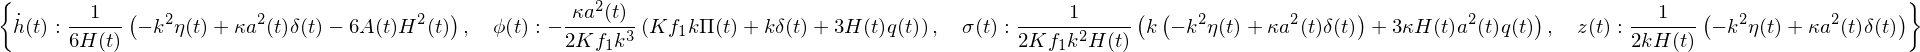

In [9]:
var_subs = subs_for_variable_set()
display(var_subs)

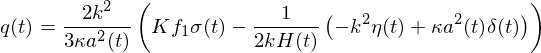

In [10]:
hdot_sub, phi_sub, sigma_sub, z_sub = [Eq(x,subs(var_subs,x)) for x in [hdot, phi, sigma, z]]

q_sub = Eq(q,subs(Eq(z,subs(var_subs,z)),solve(cons3,q)))
q_sub


In [11]:
dz = -H*z - kappa*a**2/k/2*(delta+3*delta_P) + (3*kappa*a**2*(rho+P)/2)*A/k+k*K_fac*A

In [12]:
dsigma=-H*sigma+k*(phi+A)-half*kappa*a**2/k*Pi

In [13]:
deta = -1/k*(2*K*z + kappa*a**2*q +2*K_fac*k*H*A)

In [14]:
dphi = -H*phi+half/k**2*kappa*a**2*(k*(rho+P)*sigma+k*q-diff(Pi,t)-H*Pi)

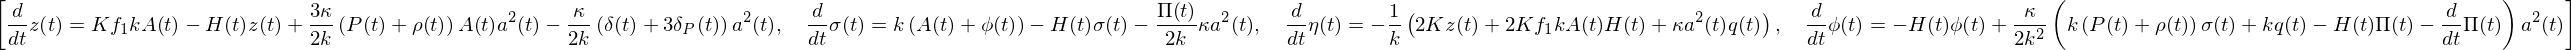

In [15]:
pert_eqs = [
    Eq(diff(z,t),dz),
    Eq(diff(sigma,t),dsigma),
    Eq(diff(eta,t),deta),
    Eq(diff(phi,t), dphi)]
pert_eqs

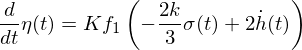

In [16]:
assert(subs(K_sub,subs(var_subs,subs(q_sub,deta).simplify()-K_fac*(2*hdot - 2*k/3*sigma))).simplify()==0)
Eq(diff(eta,t), K_fac*(2*hdot-2*k/3*sigma)) 

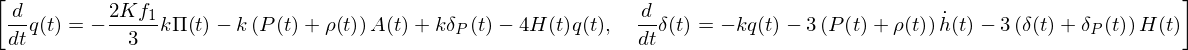

In [17]:
drag_t=opacity*(4*v_b/3-q_g)
dgrho_t =kappa*a**2*delta;

total_eqs = [
     Eq(diff(q,t),k*delta_P-4*H*q-2*third*k*K_fac*Pi -(rho+P)*k*A),
     Eq(diff(delta,t),-k*q - 3*H*(delta + delta_P) - 3*hdot*(rho+P))
]

tot_eqs = total_eqs + pert_eqs + background_eqs
total_eqs

In [18]:
if checks:
    #check consistency of constraint equations with evolution equations
    assert(subs(var_subs,subs(tot_eqs,diff(cons3,t))).simplify()==0)
    assert(subs(Friedmann,subs(var_subs,subs(tot_eqs,diff(cons2,t))).simplify()).simplify()==0)
    assert(subs(K_sub,subs(Friedmann,subs(var_subs,subs(tot_eqs,diff(cons1,t))).simplify())).simplify()==0)

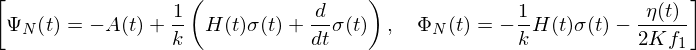

In [19]:
#Newtonian gauge variables in general. Note sigma here is the shear, Pi the anisotropic stress
Newt_vars = [Eq(Psi_N, -A + (diff(sigma,t)+H*sigma)/k), Eq(Phi_N,-eta/2/K_fac - H*sigma/k)]
if checks:
    assert(subs(var_subs,subs(pert_eqs,subs(Newt_vars,Phi_N+Psi_N-2*phi))).simplify()==0)
Newt_vars

Newtonian gauge variables $\Psi_N$ and $\Phi_N$ (not used in CAMB but may be useful) defined for metrix sign choices so flat metric is
$$ds^2 = a(\eta)^2\left( (1+2\Psi_N)d\eta^2 - (1-2\Phi_N)\delta_{ij}dx^idx^j\right)$$
(default, as defined by [Ma and Bertschinger](https://arxiv.org/abs/astro-ph/9506072), number count and 21cm papers, etc.)


The alternative definition
$$ds^2 = a(\eta)^2\left( (1+2\Psi_N)d\eta^2 - (1+2\Phi_N)\delta_{ij}dx^idx^j\right)$$
is used by [Hu et.al.](https://arxiv.org/abs/astro-ph/9709066), lensing review, etc, corresponding to a sign change in $\Phi_N$.


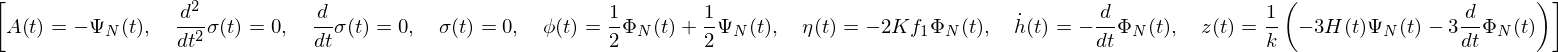

In [20]:
Newtonian_var_subs = [Eq(Phi_N,phi+half*a**2*kappa*Pi/k**2),
                   Eq(Psi_N,phi-half*a**2*kappa*Pi/k**2)]

#Newtonian gauge has zero shear
Newtonian_subs = [ Eq(A, -Psi_N), Eq(diff(sigma,t,t),0), Eq(diff(sigma,t),0), 
             Eq(sigma,0), Eq(phi,(Phi_N+Psi_N)/2), Eq(eta, -2*Phi_N*K_fac), Eq(hdot, -diff(Phi_N,t))]
Newtonian_subs+= [Eq(z,subs(Newtonian_subs,solve(cons4, z)))]

def newtonian_gauge(x):
    if isinstance(x,(list,tuple)):
        res= [newtonian_gauge(y) for y in x]
        return [ x for x in res if x != True]
    res = subs(Newtonian_subs,x)
    if isinstance(res,sympy.Expr):
        res = simplify(res.doit())
        res2 = simplify(res.subs(Psi_N, Phi_N - a**2*kappa*Pi/k**2))
        if len(str(res2)) < len(str(res)):
            res= res2
    return res


if checks:
    assert(newtonian_gauge(dsigma)==0)

Newtonian_subs

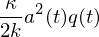

In [21]:
#e.g. get the Newtonian gauge equation for diff(Phi,t) + H*Psi 
#[eq 23b of Ma and Bertschinger, noting that their (rho+P)theta = k q since q = (rho+P)v]
newtonian_gauge(subs(tot_eqs,subs(Newtonian_var_subs,(diff(Phi_N,t) + H*Psi_N)).simplify().doit()))

In [22]:
#Relations for setting the sychronous gauge. note however that hdot and eta still differ from Ma & Bertshinger by factors
#zero acceleration, comoving with CDM
cdm_subs = [Eq(diff(A,t),0), Eq(A,0), Eq(v_c,0)]
def cdm_gauge(x):
    if isinstance(x,(list,tuple)):
        return [cdm_gauge(y) for y in x]
    return simplify(subs(cdm_subs,x))
    

Define synchonous gauge variables in Ma and Bertschinger notation (generalized to non-flat)

In terms of [Hu et al](https://arxiv.org/abs/astro-ph/9709066) variables $h_L+ h_T/3 = \eta_s$ and $h_L = -h_s/6$

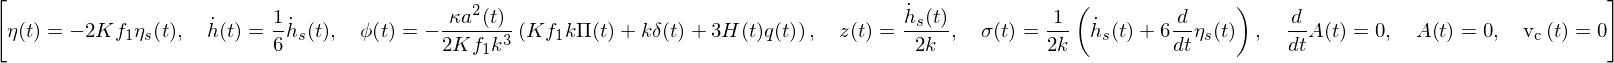

In [23]:
synchronous_var_subs = [Eq(eta_s,-make_gauge_invariant(eta, v_c)/2/K_fac), 
                        Eq(hdot_s,6*(hdot + H*A + v_c/k*(k**2/3*K_fac + kappa*a**2/2*(rho+P))))]

synchronous_subs = [Eq(eta,-2*K_fac*eta_s), Eq(hdot,hdot_s/6), Eq(phi,subs(var_subs,phi))]
synchronous_subs += [subs(synchronous_subs, Eq(z, solve(cons4,z))), 
                                Eq(sigma,(hdot_s+diff(6*eta_s,t))/2/k)]

synchronous_subs = cdm_gauge(synchronous_subs) + cdm_subs

def synchronous_gauge(x, convention=1):
    if isinstance(x,(list,tuple)):
        res = [synchronous_gauge(y) for y in x]
        return [ x for x in res if x != True]
    res = subs(synchronous_subs,x)
    if isinstance(res, sympy.Expr):
        return simplify(res.doit())
    return simplify(res)

if checks:
    assert(subs(K_sub,subs(var_subs,subs(pert_eqs,subs(cdm_gauge(synchronous_var_subs),subs(synchronous_subs,sigma) - sigma)
                              .doit())).simplify().collect(eta)).simplify()==0)

synchronous_subs

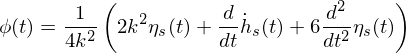

In [24]:
#Alternative pure-metric expression for phi
Eq(phi,subs(Eq(Pi,-(3*diff(eta_s,t,t)+diff(hdot_s,t)/2 + 2*(3*H*diff(eta_s,t) + H*hdot_s/2) - k**2*eta_s)/kappa/a**2),
 synchronous_gauge(subs(solve(constraints[1:],[delta,q,A]), phi_sub).rhs)).simplify())

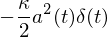

In [25]:
#Check the four synchronous gauge equations
synchronous_gauge(subs(var_subs,subs(synchronous_var_subs, K_fac*k**2*eta_s-H*hdot_s/2)).simplify())

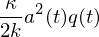

In [26]:
synchronous_gauge(subs(pert_eqs,subs(synchronous_var_subs, -K/2*hdot_s/k**2 + K_fac*diff(eta_s,t)).doit()))

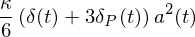

In [27]:
synchronous_gauge(subs(K_sub,subs(Friedmann,subs(var_subs,subs(total_eqs,subs(background_eqs,subs(pert_eqs,subs(var_subs,
        subs(synchronous_var_subs, -(diff(hdot_s,t) + H*hdot_s)/6).doit()).doit())).simplify().expand())
    ).simplify().expand())).simplify())

In [28]:
#Seems to be a factor of 2 missing in last line of eq A8 of Hu et al.
synchronous_gauge(subs(q_sub,subs(K_sub,subs(Friedmann_Kfac_subs,subs(var_subs,
    subs(tot_eqs+background_eqs, subs(var_subs,subs(pert_eqs,subs(synchronous_var_subs,
    3*diff(eta_s,t,t)+diff(hdot_s,t)/2 + 2*(3*H*diff(eta_s,t) + H*hdot_s/2) - k**2*eta_s).doit()).doit()).doit()))
                  .simplify()))))

In [29]:
#Fluid components

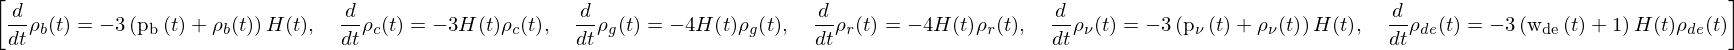

In [30]:
density_eqs = [
 Eq(diff(rho_b,t),-3*H*(rho_b+p_b)),
 Eq(diff(rho_c,t),-3*H*(rho_c)),
 Eq(diff(rho_g,t),-4*H*(rho_g)),
 Eq(diff(rho_r,t),-4*H*(rho_r)),
 Eq(diff(rho_nu,t),-3*H*(rho_nu+p_nu)),
 Eq(diff(rho_de,t),-3*H*(rho_de*(1+w_de)))
]
density_eqs


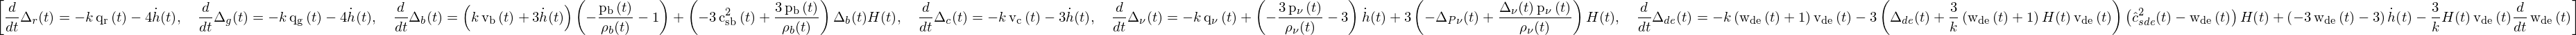

In [31]:
delta_eqs = [
   Eq(diff(Delta_r,t),-4*hdot-k*q_r),
   Eq(diff(Delta_g,t),-4*hdot-k*q_g),
   Eq(diff(Delta_b,t),-(1+p_b/rho_b)*(3*hdot+k*v_b)
                       +(p_b/rho_b-csq_b)*3*H*Delta_b),
   Eq(diff(Delta_c,t), -3*hdot -k*v_c),
   Eq(diff(Delta_nu,t), -3*(1+p_nu/rho_nu)*hdot 
            - k*q_nu +3*H*(-Delta_P_nu + Delta_nu*p_nu/rho_nu)),
   Eq(diff(Delta_de,t), 
      -3*(1+w_de)*hdot-(1+w_de)*k*v_de-3*H*(csqhat_de-w_de)*(Delta_de+3*H*(1+w_de)*v_de/k)
     - 3*H*diff(w_de,t)*v_de/k)  
]
delta_eqs

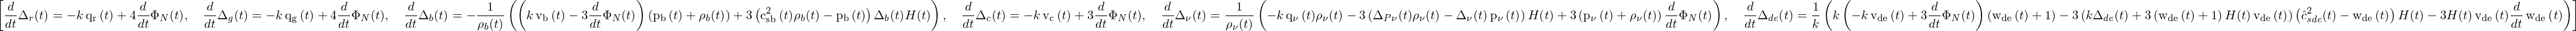

In [32]:
newtonian_gauge(delta_eqs)

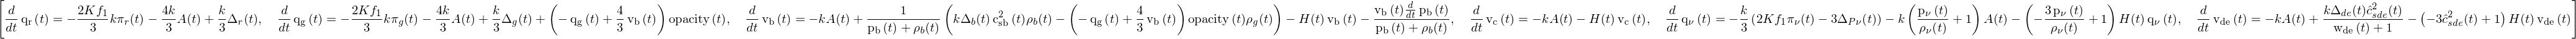

In [33]:
vel_eqs = [
    Eq(diff(q_r,t),-2*third*k*pi_r*K_fac+third*k*Delta_r-4*k/3*A), 
    Eq(diff(q_g,t),-2*third*k*pi_g*K_fac+third*k*Delta_g+drag_t-4*k/3*A),
    Eq(diff(v_b,t),-k*A-H*v_b - diff(p_b,t)*v_b/(rho_b+p_b)
              +1/(rho_b+p_b)*(rho_b*csq_b*k*Delta_b-rho_g*drag_t)),
    Eq(diff(v_c,t),-H*v_c-k*A),
    Eq(diff(q_nu,t),-H*(1-3*p_nu/rho_nu)*q_nu 
             -k/3*(2*K_fac*pi_nu - 3*Delta_P_nu)-(1+p_nu/rho_nu)*k*A),
    Eq(diff(v_de,t),k*csqhat_de*Delta_de/(1+w_de)-H*(1-3*csqhat_de)*v_de - k*A )
]
vel_eqs

In [34]:
component_eqs = density_eqs + delta_eqs + vel_eqs

In [35]:
#check all equations are gauge invariant
if checks:
    for eq in delta_eqs + vel_eqs:
        res=simplify(subs(component_eqs+background_eqs,make_gauge_invariant(eq.lhs).doit()
                  -make_gauge_invariant(eq.rhs)))
        if res:
            display(eq)
            display(res)            
            raise Exception('Non-zero')


In [36]:
def Newtonian(exp):
    return make_gauge_invariant(expr,'Newtonian')


In [37]:
#Gauge invariant quantities equivalent to the Newtonian gauge variables
delta_N = delta - 3*(rho+P)*H*sigma/k
Delta_g_N = Delta_g - 4*H*sigma/k
Delta_r_N = Delta_r - 4*H*sigma/k
Delta_c_N = Delta_c - 3*H*sigma/k
Delta_b_N = Delta_b - 3*H*sigma/k
Delta_nu_N= Delta_nu - 3*(1+p_nu/rho_nu)*H*sigma/k
Delta_de_N= Delta_de - 3*(1+w_de)*H*sigma/k
q_N = q + (rho+P)*sigma
v_b_N = v_b + sigma
v_c_N = v_c + sigma
v_de_N = v_de + sigma
q_r_N=  q_r + 4*sigma/3
q_g_N=  q_g + 4*sigma/3
q_nu_N = q_nu + (1+p_nu/rho_nu)*sigma
sigma_N = 0
eta_N =eta + 2*K_fac*H*sigma/k
hdot_N = hdot + diff(H*sigma,t)/k - k*sigma/3
A_N = A - diff(sigma,t)/k - H*sigma/k
z_N = make_gauge_invariant(z,'Newtonian')
csq_b_N = (csq_b*Delta_b + diff(p_b,t)/rho_b*sigma/k)/Delta_b_N 

Newtonian gauge version:


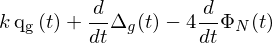

CDM frame version:


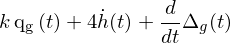

Synchronous gauge variable version:


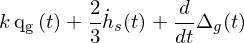

OK


In [38]:
#Gauge invariant quantities equivalent to the cdm frame (synchronous gauge) variables
delta_sync = delta + 3*H*(rho+P)*v_c/k
Delta_g_sync = Delta_g + 4*H*v_c/k
Delta_r_sync = Delta_r + 4*H*v_c/k
Delta_c_sync = Delta_c + 3*H*v_c/k
Delta_b_sync = Delta_b + 3*H*v_c/k
Delta_nu_sync= Delta_nu + 3*(1+p_nu/rho_nu)*H*v_c/k
Delta_de_sync= Delta_de + 3*(1+w_de)*H*v_c/k
q_sync = q - (rho+P)*v_c
v_b_sync = v_b-v_c
v_c_sync = 0
v_de_sync = v_de - v_c
q_r_sync=  q_r - 4*v_c/3
q_g_sync=  q_g - 4*v_c/3
q_nu_sync = q_nu - (1+p_nu/rho_nu)*v_c
sigma_sync = v_c + sigma
A_sync = 0
eta_sync =eta -2*K_fac*H*v_c/k
hdot_sync = hdot- diff(H*v_c,t)/k + k*v_c/3
z_sync = 3*hdot_sync/k    
csq_b_sync = (csq_b*Delta_b + diff(p_b,t)/rho_b*v_c/k)/Delta_b_sync 

def show_gauges(x):
    print 'Newtonian gauge version:'
    display(newtonian_gauge(x))
    print 'CDM frame version:'
    display(cdm_gauge(x))
    print 'Synchronous gauge variable version:'
    display(synchronous_gauge(x))


def check_equation(camb_eq, view = True, p_b_zero=False):
    if view:
        show_gauges(camb_eq)
    res = simplify(subs(component_eqs,camb_eq.simplify()))
    if p_b_zero: res = subs(Eq(p_b,0),res).doit().simplify()
    if res==0:
        print 'OK'
    else:
        print 'Non-zero, equal to:'
        display(res)

#For example CAMB implements the equation d Delta_g/dt= -k*(4/3*z+qg) in synchronous gauge. Check this works.
check_equation(diff(Delta_g_sync,t) + k*(4*z_sync/3 + q_g_sync)) 

Newtonian gauge version:


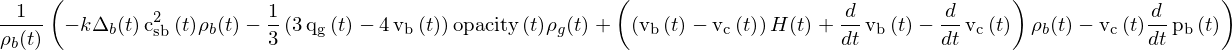

CDM frame version:


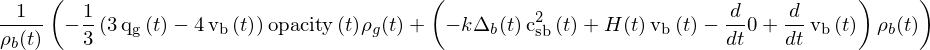

Synchronous gauge variable version:


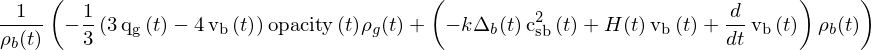

OK


In [39]:
check_equation(diff(v_b_sync,t)+H*v_b_sync
                    -csq_b_sync*k*Delta_b_sync+rho_g/rho_b*opacity*(4*v_b_sync/3-q_g_sync),p_b_zero=True)

Newtonian gauge version:


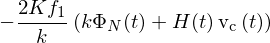

CDM frame version:


Synchronous gauge variable version:


In [40]:
#can see how a synchronous gauge variable used in CAMB can be obtained in Newtonian gauge, e.g.
show_gauges(eta_sync)

Newtonian gauge version:


CDM frame version:


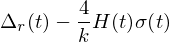

Synchronous gauge variable version:


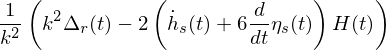

In [41]:
show_gauges(Delta_r_N)

Newtonian gauge version:


CDM frame version:


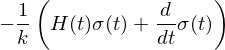

Synchronous gauge variable version:


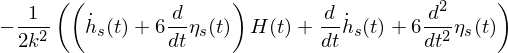

In [42]:
show_gauges(A_N)

In [43]:
rho_t =rho_b+rho_c+rho_r+rho_g+rho_nu+ rho_de

In [44]:
P_t=third*(rho_r+rho_g)+p_b+p_nu + w_de*rho_de

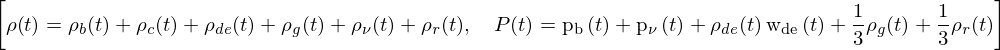

In [45]:
tot_subs = [
    Eq(rho, rho_t),
    Eq(P, P_t)
]
tot_subs

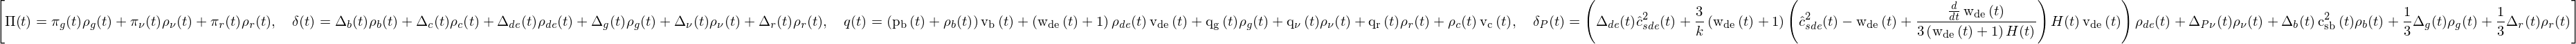

In [46]:
#Note that csqhat_de is defined in the dark energy rest-frame, so this is general-gauge result for pressure perturbation:
Delta_P_de =  (csqhat_de*Delta_de + 3*H*v_de/k*(1+w_de)*(csqhat_de-w_de + diff(w_de,t)/3/H/(1+w_de)))
tot_pert_subs = [
    Eq(Pi, rho_g*pi_g+rho_r*pi_r + rho_nu*pi_nu),
    Eq(delta,rho_g*Delta_g+rho_r*Delta_r+rho_b*Delta_b+rho_c*Delta_c 
             +rho_nu*Delta_nu + rho_de*Delta_de),
    Eq(q,rho_g*q_g+rho_r*q_r+rho_c*v_c+(rho_b+p_b)*v_b + rho_nu*q_nu+ rho_de*(1+w_de)*v_de),
    Eq(delta_P,rho_nu*Delta_P_nu + third*(rho_g*Delta_g+rho_r*Delta_r) +csq_b*Delta_b*rho_b
        + Delta_P_de*rho_de)

]
tot_pert_subs

In [47]:
def define_variable(name, namespace = globals(), order=1):
    if not name in namespace:
        namespace[name] = sympy.Function(name, perturbation_order=order)(t)
    return namespace[name]  
    
def define_variables(names, namespace = globals(), order =1):
    return [define_variable(name, namespace,order) for name in names.split()]
        
        
def make_index_func(name,l, namespace = globals()):
    name += '_'+str(l)
    return define_variable(name, namespace)

#Boltzmann hierarchies. Haven't included massive neutrinos here as yet.
def J_eq(l):
  #photons
  assert(l>1) 
  Gl = make_index_func('J',l)
  Glp = make_index_func('J',l+1)
  Glm = make_index_func('J',l-1)
  eq=-k/(2*l+1)*( (l+1)*Kf[l]*Glp - l*Glm) - opacity*Gl
  if l==2: eq = eq +  8*k/15*sigma + opacity*polter
  return Eq(diff(Gl,t),eq).subs({'J_2(t)' : pi_g, 'J_1(t)': q_g})

def G_eq(l):
  #massless neutrinos
  assert(l>1) 
  Gl = make_index_func('G',l)
  Glp = make_index_func('G',l+1)
  Glm = make_index_func('G',l-1)
  eq=-k/(2*l+1)*( (l+1)*Kf[l]*Glp - l*Glm);
  if l==2: eq = eq +  8*k/15*sigma
  return Eq(diff(Gl,t),eq).subs({'G_2(t)': pi_r,'G_1(t)': q_r})

def E_eq(l):
  #E polarization  
  assert(l>1)
  El = make_index_func('E',l)
  Elp = make_index_func('E',l+1)
  Elm = make_index_func('E',l-1)
  eq = -k/(2*l+1)*( (l+3)*(l-1)*Kf[l]*Elp/(l+1) - l*Elm)-opacity*El;
  if l==2:
    eq = eq +polter*opacity
  return Eq(diff(El,t),eq).subs('E_1(t)', 0)


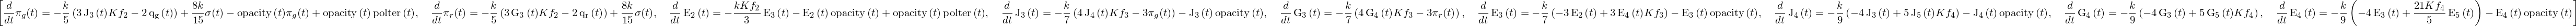

In [48]:
hierarchies = []
for l in range(2,5):
    hierarchies+= [J_eq(l), G_eq(l), E_eq(l)]
hierarchies    

In [49]:
#Check consistency of fluid equations with equations from total stress-energy conservation
for eq in total_eqs:
    assert(subs(component_eqs+tot_subs,subs(tot_pert_subs,eq).doit()).doit().simplify())

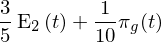

In [50]:
polter_t = sympy.Rational(2,15)*(3*pi_g/4 + 9*E_2/2)
#quadrupole source =15*polter_t/8
polter_t

In [51]:
#Line of sight temperature anisotropy source

source1 = k*sigma*exptau +visibility*15*polter/8
source = source1/3+diff(source1,t,t)/k**2 +visibility*Delta_g/4-hdot*exptau +diff(visibility*v_b-k*exptau*A,t)/k

In [52]:
src=subs(var_subs,subs(background_eqs+pert_eqs,subs(background_eqs+pert_eqs,source).expand().doit()).simplify()).simplify().expand()

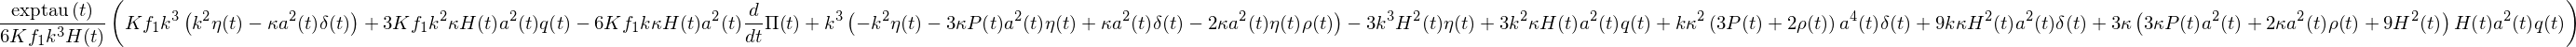

In [53]:
ISW = src.coeff(exptau)*exptau
ISW.simplify()

In [54]:
#Check ISW is just 2*d phi/d eta
assert(subs(K_sub,subs(Friedmann,subs(K_sub,subs(Friedmann,subs(var_subs,2*dphi*exptau - ISW).simplify())).simplify())).simplify()==0)

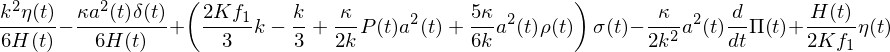

In [99]:
#More numerically stable form of phidot (but shorter than term in ISW above, which is also OK)
dphi2=subs(Friedmann_Kfac_subs,subs(q_sub,subs(var_subs, dphi)).expand()).simplify().expand().collect(sigma)
dphi2

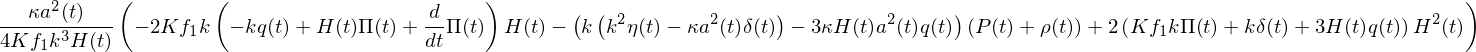

In [55]:
subs(var_subs,dphi).simplify()

In [56]:
Doppler = subs(var_subs,subs(pert_eqs,diff(visibility*(v_b+sigma),t)/k)).simplify().collect(visibility)

In [57]:
remainder = src - ISW-Doppler

In [58]:
remainder=remainder.simplify().collect(visibility)

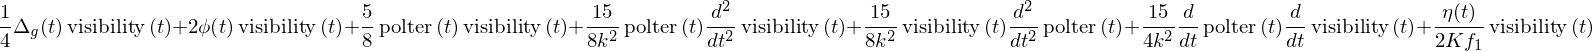

In [59]:
remainder=remainder.subs(delta,solve(phi_sub, delta)).simplify()
remainder

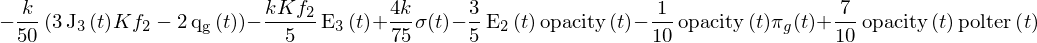

In [60]:
polterdot = subs(hierarchies,diff(polter_t,t))
polterdot

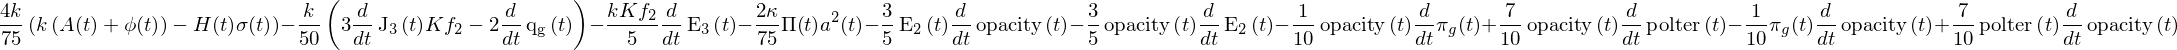

In [61]:
diff(polterdot,t).subs(diff(sigma,t),dsigma).simplify()

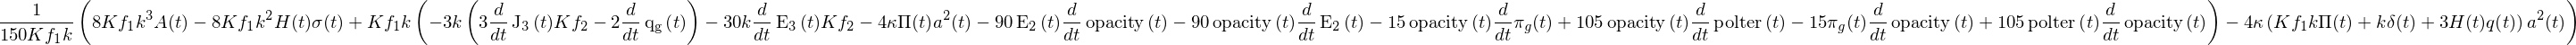

In [62]:
polterddot = subs(phi_sub,diff(polterdot,t).subs(diff(sigma,t),dsigma).simplify()).simplify()
polterddot

In [63]:
monopole_source = Delta_g*visibility/4  
sachs_wolfe = 2*phi*visibility + eta*visibility/(2*K_fac) 
quadrupole_source = (remainder-sachs_wolfe - monopole_source).simplify()
dop = diff((v_b+sigma)*visibility,t)/k
#check this is equal to the form of the Doppler source above
if checks:
    assert(subs(var_subs,subs(pert_eqs,(dop-Doppler))).simplify()==0)

In [105]:
#for translation in source output routine (does not include all equation variable)

camb_cache={}
camb_diff_vars = 'etakdot qgdot qrdot vbdot pigdot pirdot pinudot '+ \
                 'octg octgdot polterdot polterddot diff_rhopi sigmadot phidot  ' +\
                 'ddvisibility dvisibility dopacity ddopacity'
camb_arr_vars = 'Edot E'

def camb_fortran(expr, name= 'camb_function', expand =False):
    var_subs = []
    for var in expr.atoms(Function):
        camb_var = getattr(var,'camb_var',None)
        if camb_var: 
            camb_var = define_variable(camb_var)
        camb_sub = getattr(var, 'camb_sub', None) or camb_var
        if camb_sub:
            if isinstance(camb_sub,six.string_types): camb_sub = eval(camb_sub)
            var_subs.append((var, camb_sub))

    j = camb_cache.setdefault('j',sympy.Idx('j'))
    etakdot, qgdot, qrdot, vbdot, pigdot, pirdot, pinudot, octg, octgdot, \
        polterdot, polterddot, diff_rhopi, sigmadot, phidot, \
        ddvisibility, dvisibility, dopacity, ddopacity = \
        define_variables(camb_diff_vars,camb_cache)
    Edot, E= \
        sympy.symbols(camb_arr_vars, cls= sympy.IndexedBase, shape=(sympy.oo,))

    #Keep everything except baryons pressure which is very small
    camb_diff_subs= [(diff(q_g,t),qgdot),(diff(pi_g,t),pigdot),(diff(pi_r,t),pirdot),
               (diff(q_r,t),qrdot),(diff(v_b,t),vbdot),(diff(a,t), a*adotoa), 
               (diff(visibility,t,t),ddvisibility),(diff(visibility,t),dvisibility), 
                     (diff(opacity,t,t),ddopacity), (diff(opacity,t),dopacity),
               (diff(J_3,t),octgdot), (diff(E_2,t),Edot[2]),
               (diff(E_3,t),Edot[3]),(diff(pi_nu,t),pinudot),
               (diff(eta,t),-2*etakdot/k), (diff(Pi,t), diff_rhopi/kappa/a**2),
               (diff(polter,t,t),polterddot),(diff(polter,t),polterdot),
                    (diff(sigma,t), sigmadot), (diff(phi,t), phidot), (diff(p_b,t),0)]

    camb_subs= var_subs + [(p_b,0),(E_2,E[2]),(E_3,E[3]), (J_3, octg), (K_fac,Kf[1])]
    
    res = cdm_gauge(expr).subs(camb_diff_subs)
    if 'Derivative' in str(res):
        raise Exception('Remaining derivatives: ' + str(res))
    res = res.subs(camb_subs).simplify()
    if True:
        no_arg_funcs = [f for f in res.atoms(Function) if f.args[0]==t]
        res = res.subs(zip(no_arg_funcs, [sympy.Symbol(str(x.func)) for x in no_arg_funcs]))
    if expand: res = res.expand()
    res = res.collect([sympy.Symbol(str(x.func)) for x in [k,sigma,adotoa,opacity, visibility, dopacity, dvisibility, ddvisibility]])
    if True:
        res =  sympy.fcode(res, source_format='free', standard=95,  assign_to = name, contract=False )
        lines  = res.split('\n')
        for i,line in enumerate(lines):
            if '=' in line:
                res = '\n'.join(lines[i:])
                break
    else:
        #res = autowrap(res, tempdir=r'z:',)
        
        res = codegen((name, res), 'f95', 'my_project', header=False)[0][1]
        print res
        lines  = res.split('\n')
        for i,line in enumerate(lines):
            if '=' in line:
                res = '\n'.join(lines[i:-2])
                break
    res = ''.join([x.strip() for x in res.split('&')]).replace('Kf', 'EV%Kf')    
    import textwrap
    res = ' &\n    '.join(textwrap.wrap(res))
    return res    

In [106]:
print camb_fortran(dphi2, 'phidot')
print camb_fortran(dsigma, 'sigmadot')
print camb_fortran(diff(polter_t,t), 'polterdot')
print camb_fortran(polterddot, 'polterddot')
print camb_fortran(2*diff(phi,t)*exptau,'ISW')
print camb_fortran(sachs_wolfe, 'sachs_wolfe', expand=True)
print camb_fortran(monopole_source, 'monopole_source')
print camb_fortran(dop, 'doppler')
print camb_fortran(quadrupole_source, 'quadrupole_source')


phidot = -adotoa*etak/(k*EV%Kf(1)) - 1.0d0/2.0d0*diff_rhopi/k**2 + &
    sigma*((1.0d0/2.0d0)*gpres/k + (5.0d0/6.0d0)*grho/k + &
    (2.0d0/3.0d0)*k*EV%Kf(1) - 1.0d0/3.0d0*k) + (-1.0d0/6.0d0*dgrho - &
    1.0d0/3.0d0*etak*k)/adotoa
sigmadot = -adotoa*sigma - 1.0d0/2.0d0*dgpi/k + k*phi
polterdot = (1.0d0/10.0d0)*pigdot + (3.0d0/5.0d0)*Edot(2)
polterddot = -2.0d0/25.0d0*adotoa*dgq/(k*EV%Kf(1)) - &
    4.0d0/75.0d0*adotoa*k*sigma - 4.0d0/75.0d0*dgpi - &
    2.0d0/75.0d0*dgrho/EV%Kf(1) + dopacity*(-1.0d0/10.0d0*pig + &
    (7.0d0/10.0d0)*polter - 3.0d0/5.0d0*E(2)) &
    -3.0d0/50.0d0*k*octgdot*EV%Kf(2) + (1.0d0/25.0d0)*k*qgdot - &
    1.0d0/5.0d0*k*Edot(3)*EV%Kf(2) + opacity*(-1.0d0/10.0d0*pigdot + &
    (7.0d0/10.0d0)*polterdot - 3.0d0/5.0d0*Edot(2))
ISW = 2*exptau*phidot
sachs_wolfe = visibility*(-etak/(k*EV%Kf(1)) + 2*phi)
monopole_source = (1.0d0/4.0d0)*clxg*visibility
doppler = (dvisibility*(sigma + vb) + visibility*(sigmadot + vbdot))/k
quadrupole_source = (5.0d0/8.0d0)*(3*ddvisibili

In [66]:
items=[]
for x in globals():
    if getattr(globals()[x],'camb_var',None):
        items.append(globals()[x].camb_var)
",".join(items)

'cs2,adotoa,clxq,gpres,pir,pig,clxr,vq,dgpi,grhog_t,grhoc_t,grhob_t,etak,grhor_t,qnu,grhonu_t,pinu,clxnu,dgq,w_lam,vb,cs2_lam,grhov_t,dgrho,clxg,clxb,clxc,qg,qr,grho'

In [67]:
print os.path.abspath(os.path.dirname(camb.__file__))


c:\work\dist\git\camb\pycamb\camb


In [68]:
import shutil, struct, subprocess
import ctypes

"""
 Type TTimeVars
         real(dl) adotoa, a, grho, gpres, w_de, cs2_de, &
            etak, etakdot, phi, phidot, sigma, sigmadot, &  
            dgrho, clxg,clxb,clxc,clxnu, clxq, &
            dgq, qg, qr, vq, vb, qnu, qgdot, qrdot, vbdot, &
            dgpi, pig, pir, pinu, pigdot, pirdot, pinudot, diff_rhopi, &
            polter, polterdot, polterddot, &
            E(3), Edot(3), octg, octgdot, &
            opac, dopac, &
            reserved(8)
    end Type TTimeVars
"""

testpath='z:\\'
source_file_count = globals().setdefault('source_file_count',0)+1
template = """
REAL*8 function source_func(t, a, adotoa, grho, gpres,w_lam, cs2_lam,  &
        k, Kf, etak, etakdot, phi, phidot, sigma, sigmadot, &  
        dgrho, clxg,clxb,clxc,clxnu, clxq, &
        dgq, qg, qr, vq, vb, qnu, qgdot, qrdot, vbdot, &
        dgpi, pig, pir, pinu, pigdot, pirdot, pinudot, diff_rhopi, &
        polter, polterdot, polterddot, &
        octg, octgprime, ypol, ypolprime, &
        opac, vis, expmmu, ddvis, dvis, dopac)
implicit none
use ThermoData
use ModelData
   
REAL*8, intent(in) :: t, a, adotoa, grho, gpres,w_lam, cs2_lam,  &
        k, Kf(*), etak, etakdot, phi, phidot, sigma, sigmadot, &  
        dgrho, clxg,clxb,clxc,clxnu, clxq, &
        dgq, qg, qr, vq, vb, qnu, qgdot, qrdot, vbdot, &
        dgpi, pig, pir, pinu, pigdot, pirdot, pinudot, diff_rhopi, &
        polter, polterdot, polterddot, &
        octg, octgprime, ypol, ypolprime, &
        opac, vis, expmmu, ddvis, dvis, dopac

source_func = -adotoa*sigma - 1.0d0/2.0d0*dgpi/k + k*phi
end function
"""

COMPILER = "gfortran"
FFLAGS = "-shared -static -O1 -ffast-math -fmax-errors=4 -J"
if struct.calcsize("P") == 4: FFLAGS = "-m32 " + FFLAGS
DLLNAME='tester%s.dll'%source_file_count

workdir = testpath or tempfile.mkdtemp("_camb_compile")
if not os.access(workdir, os.F_OK):
    os.mkdir(workdir)
oldwork = os.getcwd()
os.chdir(workdir)
source_file = os.path.join(workdir, 'code.f90')
with open(source_file, 'w') as f:
    f.write(template)
        
OUTPUT = r"-o %s" % (DLLNAME)
print(COMPILER + ' ' + FFLAGS + ' ' + source_file + ' ' + OUTPUT)
subprocess.call(COMPILER + ' ' + FFLAGS + ' ' + source_file + ' ' + OUTPUT, shell=True)
func_lib = ctypes.LibraryLoader(ctypes.CDLL).LoadLibrary(DLLNAME)
func = func_lib.source_func_
if not testpath:
    shutil.rmtree(workdir)
os.chdir(oldwork)

gfortran -shared -static -O1 -ffast-math -fmax-errors=4 -J z:\code.f90 -o tester1.dll


In [69]:
func_lib.source_func_

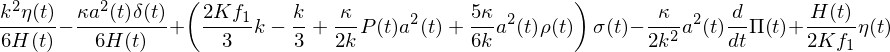

In [96]:
dphi2=subs(Friedmann_Kfac_subs,subs(q_sub,subs(var_subs, dphi)).expand()).simplify().expand().collect(sigma)
dphi2

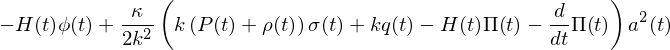

In [74]:
dphi

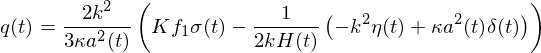

In [75]:
q_sub

In [93]:
print camb_fortran(dphi2, 'doppler')

doppler = -adotoa*etak/(k*EV%Kf(1)) - 1.0d0/2.0d0*diff_rhopi/k**2 + &
    (1.0d0/2.0d0)*gpres*sigma/k + (5.0d0/6.0d0)*grho*sigma/k + &
    (2.0d0/3.0d0)*k*sigma*EV%Kf(1) - 1.0d0/3.0d0*k*sigma - &
    1.0d0/6.0d0*dgrho/adotoa -1.0d0/3.0d0*etak*k/adotoa


In [81]:
print camb_fortran(ISW/2/exptau)

camb_function = (1.0d0/12.0d0)*(9*adotoa**2*dgrho*k + &
    6*adotoa**2*etak*k**2 + 3*adotoa*dgq*k**2*EV%Kf(1) + 3*adotoa*dgq*k**2 &
    + 3*adotoa*dgq*(9*adotoa**2 + 3*gpres + 2*grho) - &
    6*adotoa*diff_rhopi*k*EV%Kf(1) +dgrho*k*(3*gpres + 2*grho) - &
    k**3*(dgrho + 2*etak*k)*EV%Kf(1) + k**2*(6*etak*gpres + 4*etak*grho + &
    k*(dgrho + 2*etak*k)))/(adotoa*k**3*EV%Kf(1))
